The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Seleção do Modelo, *Underfitting*, e *Overfitting*
:label:`sec_model_selection`


Como cientistas de *machine learning*,
nosso objetivo é descobrir *padrões*.
Mas como podemos ter certeza de que
realmente descobrimos um padrão *geral*
e não simplesmente memorizamos nossos dados?
Por exemplo, imagine que queremos caçar
 padrões entre marcadores genéticos
ligando os pacientes ao seu estado de demência,
onde os rótulos são retirados do conjunto
$\{\text{dementia}, \text{mild cognitive impairment}, \text{healthy}\}$
Como os genes de cada pessoa os identificam de forma única
(ignorando irmãos idênticos),
é possível memorizar todo o conjunto de dados.

Não queremos que nosso modelo diga
*"É o Bob! Lembro-me dele! Ele tem demência!"*
O motivo é simples.
Quando implantamos o modelo no futuro,
nós encontraremos pacientes
que o modelo nunca viu antes.
Nossas previsões só serão úteis
se nosso modelo realmente descobriu um padrão *geral*.

Para recapitular mais formalmente,
nosso objetivo é descobrir padrões
que capturam regularidades na população subjacente
da qual nosso conjunto de treinamento foi extraído.
Se tivermos sucesso neste empreendimento,
então poderíamos avaliar com sucesso o risco
mesmo para indivíduos que nunca encontramos antes.
Este problema --- como descobrir padrões que *generalizam* --- é
o problema fundamental do *machine learning*.

O perigo é que, quando treinamos modelos,
acessamos apenas uma pequena amostra de dados.
Os maiores conjuntos de dados de imagens públicas contêm
cerca de um milhão de imagens.
Mais frequentemente, devemos aprender com apenas milhares
ou dezenas de milhares de exemplos de dados.
Em um grande sistema hospitalar, podemos acessar
centenas de milhares de registros médicos.
Ao trabalhar com amostras finitas, corremos o risco
de poder descobrir associações aparentes
que acabam não se sustentando quando coletamos mais dados.

O fenômeno de ajustar nossos dados de treinamento
mais precisamente do que ajustamos, a distribuição subjacente é chamada de *overfitting*, e as técnicas usadas para combater o *overfitting* são chamadas de *regularização*.
Nas seções anteriores, você deve ter observado
esse efeito durante a experiência com o conjunto de dados *Fashion-MNIST*.
Se você alterou a estrutura do modelo ou os hiperparâmetros durante o experimento, deve ter notado que, com neurônios, camadas e períodos de treinamento suficientes, o modelo pode eventualmente atingir uma precisão perfeita no conjunto de treinamento, mesmo quando a precisão dos dados de teste se deteriora.


## Erro de Treinamento e Erro de Generalização


Para discutir este fenômeno de forma mais formal,
precisamos diferenciar entre erro de treinamento e erro de generalização.
O *erro de treinamento* é o erro do nosso modelo
conforme calculado no conjunto de dados de treinamento,
enquanto *erro de generalização* é a expectativa do erro do nosso modelo
deveríamos aplicá-lo a um fluxo infinito de exemplos de dados adicionais
extraído da mesma distribuição de dados subjacente que nossa amostra original.

De forma problemática, nunca podemos calcular o erro de generalização com exatidão.
Isso ocorre porque o fluxo de dados infinitos é um objeto imaginário.
Na prática, devemos *estimar* o erro de generalização
aplicando nosso modelo a um conjunto de teste independente
constituído de uma seleção aleatória de exemplos de dados
que foram retirados de nosso conjunto de treinamento.


Os três experimentos mentais a seguir
ajudarão a ilustrar melhor esta situação.
Considere um estudante universitário tentando se preparar para o exame final.
Um aluno diligente se esforçará para praticar bem
e testar suas habilidades usando exames de anos anteriores.
No entanto, um bom desempenho em exames anteriores não é garantia
que ele se sobressairá quando for importante.
Por exemplo, o aluno pode tentar se preparar
aprendendo de cor as respostas às questões do exame.
Isso requer que o aluno memorize muitas coisas.
Ela pode até se lembrar das respostas de exames anteriores perfeitamente.
Outro aluno pode se preparar tentando entender
as razões para dar certas respostas.
Na maioria dos casos, o último aluno se sairá muito melhor.

Da mesma forma, considere um modelo que simplesmente usa uma tabela de pesquisa para responder às perguntas. Se o conjunto de entradas permitidas for discreto e razoavelmente pequeno, talvez depois de ver *muitos* exemplos de treinamento, essa abordagem teria um bom desempenho. Ainda assim, esse modelo não tem capacidade de fazer melhor do que adivinhação aleatória quando confrontado com exemplos que nunca viu antes.
Na realidade, os espaços de entrada são muito grandes para memorizar as respostas correspondentes a cada entrada concebível. Por exemplo, considere as imagens $28\times28$ em preto e branco. Se cada pixel pode ter um entre $256$ valores de tons de cinza, então há $256^{784}$ imagens possíveis. Isso significa que há muito mais imagens em miniatura em escala de cinza de baixa resolução do que átomos no universo. Mesmo se pudéssemos encontrar esses dados, nunca poderíamos nos dar ao luxo de armazenar a tabela de pesquisa.

Por último, considere o problema de tentar classificar os resultados dos lançamentos de moeda (classe 0: cara, classe 1: coroa)
com base em alguns recursos contextuais que podem estar disponíveis.
Suponha que a moeda seja justa.
Não importa o algoritmo que criamos,
o erro de generalização sempre será $\frac{1}{2}$.
No entanto, para a maioria dos algoritmos,
devemos esperar que nosso erro de treinamento seja consideravelmente menor,
dependendo da sorte do sorteio,
mesmo se não tivéssemos nenhuma *feature*!
Considere o conjunto de dados {0, 1, 1, 1, 0, 1}.
Nosso algoritmo sem recursos teria que recorrer sempre à previsão
da *classe majoritária*, que parece ser *1* em nossa amostra limitada.
Neste caso, o modelo que sempre prevê a classe 1
incorrerá em um erro de $\frac{1}{3}$,
consideravelmente melhor do que nosso erro de generalização.
Conforme aumentamos a quantidade de dados,
a probabilidade de que a fração de caras
irá se desviar significativamente de $\frac{1}{2}$ diminui,
e nosso erro de treinamento viria a corresponder ao erro de generalização.

### Teoria de Aprendizagem Estatística


Como a generalização é o problema fundamental no *machine learning*,
você pode não se surpreender ao aprender
que muitos matemáticos e teóricos dedicaram suas vidas
para desenvolver teorias formais para descrever este fenômeno.
Em seu [teorema de mesmo nome](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem), Glivenko e Cantelli
derivaram a taxa na qual o erro de treinamento
converge para o erro de generalização.
Em uma série de artigos seminais, [Vapnik e Chervonenkis](https://en.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_theory)
estenderam esta teoria a classes de funções mais gerais.
Este trabalho lançou as bases da teoria da aprendizagem estatística.


No ambiente de aprendizagem supervisionada padrão, que abordamos até agora e manteremos ao longo da maior parte deste livro,
presumimos que tanto os dados de treinamento quanto os dados de teste
são desenhados *independentemente* de distribuições *idênticas*.
Isso é comumente chamado de *suposição i.i.d.*,
o que significa que o processo que faz a amostragem de nossos dados não tem memória.
Em outras palavras,
o segundo exemplo desenhado e o terceiro desenhado
não são mais correlacionados do que a segunda e a segunda milionésima amostra extraída.

Ser um bom cientista de *machine learning* exige pensar criticamente,
e você já deve estar cutucando buracos nessa suposição,
surgindo com casos comuns em que a suposição falha.
E se treinarmos um preditor de risco de mortalidade
em dados coletados de pacientes no UCSF Medical Center,
e aplicá-lo em pacientes no *Massachusetts General Hospital*?
Essas distribuições simplesmente não são idênticas.
Além disso, os empates podem ser correlacionados no tempo.
E se estivermos classificando os tópicos dos Tweets?
O ciclo de notícias criaria dependências temporais
nos tópicos em discussão, violando quaisquer pressupostos de independência.


Às vezes, podemos escapar impunes de violações menores da suposição i.i.d. 
e nossos modelos continuarão a funcionar muito bem.
Afinal, quase todos os aplicativos do mundo real
envolvem pelo menos alguma violação menor da suposição i.i.d.,
e ainda temos muitas ferramentas úteis para
várias aplicações, como
reconhecimento de rosto,
reconhecimento de voz e tradução de idiomas.

Outras violações certamente causarão problemas.
Imagine, por exemplo, se tentarmos treinar
um sistema de reconhecimento de rosto treinando-o
exclusivamente em estudantes universitários
e então tentar implantá-lo como uma ferramenta
para monitorar a geriatria em uma população de lares de idosos.
É improvável que funcione bem, uma vez que estudantes universitários
tendem a parecer consideravelmente diferentes dos idosos.

Nos capítulos subsequentes, discutiremos problemas
decorrentes de violações da suposição i.i.d..
Por enquanto, mesmo tomando a suposição i.i.d. como certa,
compreender a generalização é um problema formidável.
Além disso, elucidando os fundamentos teóricos precisos
isso que podem explicar por que redes neurais profundas generalizam tão bem como o fazem,
continua a irritar as maiores mentes da teoria do aprendizado.

Quando treinamos nossos modelos, tentamos pesquisar uma função
que se ajusta aos dados de treinamento da melhor maneira possível.
Se a função é tão flexível que pode pegar padrões falsos
tão facilmente quanto às associações verdadeiras,
então ele pode funcionar *muito bem* sem produzir um modelo
que generaliza bem para dados invisíveis.
Isso é exatamente o que queremos evitar ou pelo menos controlar.
Muitas das técnicas de aprendizado profundo são heurísticas e truques
visando a proteção contra *overfitting*.

### Complexidade do Modelo

Quando temos modelos simples e dados abundantes,
esperamos que o erro de generalização seja semelhante ao erro de treinamento.
Quando trabalhamos com modelos mais complexos e menos exemplos,
esperamos que o erro de treinamento diminua, mas a lacuna de generalização cresça.
O que constitui precisamente a complexidade do modelo é um assunto complexo.
Muitos fatores determinam se um modelo irá generalizar bem.
Por exemplo, um modelo com mais parâmetros pode ser considerado mais complexo.
Um modelo cujos parâmetros podem ter uma gama mais ampla de valores
pode ser mais complexo.
Muitas vezes, com redes neurais, pensamos em um modelo
que exige mais iterações de treinamento quanto mais complexas,
e um sujeito a *parada antecipada* (menos iterações de treinamento) como menos complexo.


Pode ser difícil comparar a complexidade entre os membros
de classes de modelo substancialmente diferentes
(digamos, árvores de decisão vs. redes neurais).
Por enquanto, uma regra prática simples é bastante útil:
um modelo que pode facilmente explicar fatos arbitrários
é o que os estatísticos consideram complexo,
ao passo que aquele que tem apenas um poder expressivo limitado
mas ainda consegue explicar bem os dados
provavelmente está mais perto da verdade.
Em filosofia, isso está intimamente relacionado ao
critério de falseabilidade de Popper
de uma teoria científica: uma teoria é boa se ela se encaixa nos dados
e se existem testes específicos que podem ser usados ​​para contestá-lo.
Isso é importante, pois toda estimativa estatística é
*post hoc*,
ou seja, estimamos depois de observar os fatos,
portanto, vulnerável à falácia associada.
Por enquanto, deixaremos a filosofia de lado e nos limitaremos a questões mais tangíveis.

Nesta seção, para lhe dar alguma intuição,
vamos nos concentrar em alguns fatores que tendem
para influenciar a generalização de uma classe de modelo:

1. O número de parâmetros ajustáveis. Quando o número de parâmetros ajustáveis, às vezes chamados de *graus de liberdade*, é grande, os modelos tendem a ser mais suscetíveis a *overfitting*.
2. Os valores assumidos pelos parâmetros. Quando os pesos podem assumir uma faixa mais ampla de valores, os modelos podem ser mais suscetíveis a *overfitting*.
3. O número de exemplos de treinamento. É trivialmente fácil fazer *overfitting* em um conjunto de dados contendo apenas um ou dois exemplos, mesmo se seu modelo for simples. Mas ajustar um conjunto de dados com milhões de exemplos requer um modelo extremamente flexível.


## Seleção do Modelo


No *machine learning*, geralmente selecionamos nosso modelo final
depois de avaliar vários modelos candidatos.
Este processo é denominado *seleção de modelo*.
Às vezes, os modelos que estão sujeitos a comparação
são fundamentalmente diferentes em natureza
(digamos, árvores de decisão vs. modelos lineares).
Em outras ocasiões, estamos comparando
membros da mesma classe de modelos
que foram treinados com diferentes configurações de hiperparâmetros.

Com MLPs, por exemplo,
podemos desejar comparar modelos com
diferentes números de camadas ocultas,
diferentes números de unidades ocultas,
e várias opções das funções de ativação
aplicado a cada camada oculta.
A fim de determinar o melhor entre nossos modelos candidatos,
normalmente empregaremos um conjunto de dados de validação.


### *Dataset* de Validação


Em princípio, não devemos tocar em nosso conjunto de teste
até depois de termos escolhido todos os nossos hiperparâmetros.
Se usarmos os dados de teste no processo de seleção do modelo,
existe o risco de ajustarmos demais os dados de teste (*overfitting*).
Então, estaríamos em sérios problemas.
Se ajustarmos demais nossos dados de treinamento,
há sempre a avaliação dos dados de teste para nos manter honestos.
Mas se ajustarmos demais os dados de teste, como saberemos?


Portanto, nunca devemos confiar nos dados de teste para a seleção do modelo.
E ainda não podemos confiar apenas nos dados de treinamento
para seleção de modelo porque
não podemos estimar o erro de generalização
nos próprios dados que usamos para treinar o modelo.


Em aplicações práticas, a imagem fica mais turva.
Embora o ideal seja tocar nos dados de teste apenas uma vez,
para avaliar o melhor modelo ou para comparar
um pequeno número de modelos entre si,
dados de teste do mundo real raramente são descartados após apenas um uso.
Raramente podemos pagar um novo conjunto de teste para cada rodada de experimentos.

A prática comum para resolver este problema
é dividir nossos dados de três maneiras,
incorporando um *dataset de validação* (ou *conjunto de validação*)
além dos conjuntos de dados de treinamento e teste.
O resultado é uma prática obscura onde os limites
entre a validação e os dados de teste são preocupantemente ambíguos.
A menos que seja explicitamente declarado de outra forma, nos experimentos deste livro
estamos realmente trabalhando com o que deveria ser corretamente chamado
dados de treinamento e dados de validação, sem conjuntos de teste verdadeiros.
Portanto, a precisão relatada em cada experimento do livro é realmente a precisão da validação e não uma precisão do conjunto de teste verdadeiro.

### Validação Cruzada *$K$-Fold*

Quando os dados de treinamento são escassos,
podemos nem mesmo ser capazes de resistir
dados suficientes para constituir um conjunto de validação adequado.
Uma solução popular para este problema é empregar
$validação cruzada K$*-fold*.
Aqui, os dados de treinamento originais são divididos em subconjuntos não sobrepostos de $K$.
Então, o treinamento e a validação do modelo são executados $K$ vezes,
cada vez treinando em subconjuntos $K-1$ e validando
em um subconjunto diferente (aquele não usado para treinamento nessa rodada).
Finalmente, os erros de treinamento e validação são estimados
calculando a média dos resultados dos experimentos de $K$.

## *Underfitting* ou *Overfitting*?


Quando comparamos os erros de treinamento e validação,
queremos estar atentos a duas situações comuns.
Primeiro, queremos estar atentos aos casos
quando nosso erro de treinamento e erro de validação são substanciais
mas há uma pequena lacuna entre eles.
Se o modelo não for capaz de reduzir o erro de treinamento,
isso pode significar que nosso modelo é muito simples
(ou seja, insuficientemente expressivo)
para capturar o padrão que estamos tentando modelar.
Além disso, uma vez que a *lacuna de generalização*
entre nossos erros de treinamento e validação é pequena,
temos motivos para acreditar que poderíamos sair impunes de um modelo mais complexo.
Este fenômeno é conhecido como *underfitting*.

Por outro lado, como discutimos acima,
queremos estar atentos aos casos
quando nosso erro de treinamento é significativamente menor
do que o nosso erro de validação, indicando *overfitting* severo.
Observe que o *overfitting* nem sempre é uma coisa ruim.
Especialmente no aprendizado profundo, é bem conhecido
que os melhores modelos preditivos frequentemente executam
muito melhor em dados de treinamento do que em dados de validação.
Em última análise, geralmente nos preocupamos mais com o erro de validação
do que sobre a lacuna entre os erros de treinamento e validação.

Se fazemos *underfitting* ou *overfitting* pode depender
tanto na complexidade do nosso modelo
e o tamanho dos conjuntos de dados de treinamento disponíveis,
dois tópicos que discutiremos a seguir.

### Complexidade do Modelo

Para ilustrar alguma intuição clássica
sobre *overfitting* e complexidade do modelo,
damos um exemplo usando polinômios.
Dados de treinamento dados consistindo em uma única *feature* $x$
e um rótulo de valor real correspondente $y$,
tentamos encontrar o polinômio de grau $d$

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

para estimar os rótulos $y$.
Este é apenas um problema de regressão linear
onde nossos recursos são dados pelos poderes de $x$,
os pesos do modelo são dados por $w_i$,
e o *bias* é dado por $w_0$ visto que $x^0 = 1$ para todo $x$.
Uma vez que este é apenas um problema de regressão linear,
podemos usar o erro quadrático como nossa função de perda.


Uma função polinomial de ordem superior é mais complexa
do que uma função polinomial de ordem inferior,
uma vez que o polinômio de ordem superior tem mais parâmetros
e a faixa de seleção da função do modelo é mais ampla.
Corrigindo o conjunto de dados de treinamento,
funções polinomiais de ordem superior devem sempre
alcançar menor (na pior das hipóteses, igual) erro de treinamento
em relação a polinômios de grau inferior.
Na verdade, sempre que os exemplos de dados cada um tem um valor distinto de $x$,
uma função polinomial com grau igual ao número de exemplos de dados
pode se encaixar perfeitamente no conjunto de treinamento.
Nós visualizamos a relação entre o grau polinomial
e *underfitting* vs. *overfitting* em  :numref: `fig_capacity_vs_error`.

![Influence of model complexity on underfitting and overfitting](../img/capacity-vs-error.svg)
:label:`fig_capacity_vs_error`

### Tamanho do Dataset

A outra grande consideração a ter em mente é o tamanho do *dataset*.
Corrigindo nosso modelo, menos amostras temos no *dataset* de treinamento,
o mais provável (e mais severamente) é encontrar *overfitting*.
À medida que aumentamos a quantidade de dados de treinamento,
o erro de generalização geralmente diminui.
Além disso, em geral, mais dados nunca fazem mal.
Para uma tarefa fixa e distribuição de dados,
normalmente existe uma relação entre a complexidade do modelo e o tamanho do *dataset*.
Com mais dados, podemos tentar, de maneira lucrativa, ajustar um modelo mais complexo.
Na ausência de dados suficientes, os modelos mais simples podem ser mais difíceis de superar.
Para muitas tarefas, o aprendizado profundo supera apenas os modelos lineares
quando muitos milhares de exemplos de treinamento estão disponíveis.
Em parte, o sucesso atual do aprendizado profundo
deve-se à atual abundância de enormes conjuntos de dados
devido a empresas de Internet, armazenamento barato, dispositivos conectados,
e a ampla digitalização da economia.

## Regressão Polinomial

Agora podemos (**explorar esses conceitos interativamente
ajustando polinômios aos dados.**)


In [1]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### Gerando o *Dataset*

Primeiro, precisamos de dados. Dado $x$, iremos [**usar o seguinte polinômio cúbico para gerar os rótulos**] nos dados de treinamento e teste:

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

O termo de ruído $\epsilon$ obedece a uma distribuição normal
com uma média de 0 e um desvio padrão de 0,1.
Para otimização, normalmente queremos evitar
valores muito grandes de gradientes ou perdas.
É por isso que as *features*
são redimensionadas de $x^i$ to $\frac{x^i}{i!}$.
Isso nos permite evitar valores muito grandes para grandes expoentes $i$.
Vamos sintetizar 100 amostras cada para o conjunto de treinamento e o conjunto de teste.


In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Novamente, monômios armazenados em `poly_features`
são redimensionados pela função gama,
onde $\Gamma(n)=(n-1)!$.
[**Dê uma olhada nas 2 primeiras amostras**] do conjunto de dados gerado.
O valor 1 é tecnicamente uma *feature*,
ou seja, a *feature* constante correspondente ao *bias*.


In [3]:
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.03716067],
        [-1.1468065 ]]),
 array([[ 1.0000000e+00, -3.7160669e-02,  6.9045764e-04, -8.5526226e-06,
          7.9455290e-08, -5.9052235e-10,  3.6573678e-12, -1.9415747e-14,
          9.0187767e-17, -3.7238198e-19,  1.3837962e-21, -4.6747992e-24,
          1.4476556e-26, -4.1381425e-29,  1.0984010e-31, -2.7211542e-34,
          6.3199942e-37, -1.3815009e-39,  2.8516424e-42, -5.6051939e-45],
        [ 1.0000000e+00, -1.1468065e+00,  6.5758252e-01, -2.5137332e-01,
          7.2069131e-02, -1.6529869e-02,  3.1594271e-03, -5.1760738e-04,
          7.4199430e-05, -9.4547095e-06,  1.0842722e-06, -1.1304095e-07,
          1.0803007e-08, -9.5299690e-10,  7.8064499e-11, -5.9683248e-12,
          4.2778208e-13, -2.8857840e-14,  1.8385756e-15, -1.1097316e-16]]),
 array([ 5.1432443 , -0.06415121]))

### Trainando e Testando o Modelo

Vamos primeiro [**implementar uma função para avaliar a perda em um determinado conjunto de dados**].


In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), d2l.size(l))
    return metric[0] / metric[1]

Agora [**definimos a função de treinamento**].


In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

### [**Ajuste de Função Polinomial de Terceira Ordem (Normal)**]

Começaremos usando primeiro uma função polinomial de terceira ordem, que é a mesma ordem da função de geração de dados.
Os resultados mostram que as perdas de treinamento e teste deste modelo podem ser reduzidas de forma eficaz.
Os parâmetros do modelo aprendido também estão próximos
dos valores verdadeiros $w = [5, 1.2, -3.4, 5.6]$.


weight: [[ 5.0191503  1.2219362 -3.4236343  5.571773 ]]


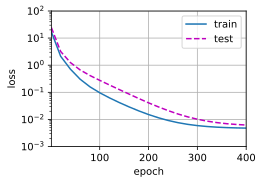

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### [**Ajuste de Função Linear (*Underfitting*)**]

Vamos dar uma outra olhada no ajuste de função linear.
Após o declínio nas primeiras épocas,
torna-se difícil diminuir ainda mais
perda de treinamento deste modelo.
Depois que a última iteração de época foi concluída,
a perda de treinamento ainda é alta.
Quando usado para ajustar padrões não lineares
(como a função polinomial de terceira ordem aqui)
os modelos lineares podem ser insuficientes e cometer *undefitting*.


weight: [[2.6986656 4.223269 ]]


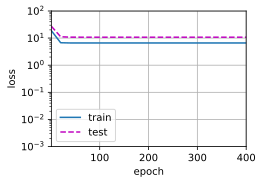

In [7]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### [**Ajuste de Função Polinomial de Ordem Superior (Overfitting)**]

Agora vamos tentar treinar o modelo
usando um polinômio de grau muito alto.
Aqui, não há dados suficientes para aprender que
os coeficientes de grau superior devem ter valores próximos a zero.
Como resultado, nosso modelo excessivamente complexo
é tão suscetível que está sendo influenciado
por ruído nos dados de treinamento.
Embora a perda de treinamento possa ser efetivamente reduzida,
a perda de teste ainda é muito maior.
Mostra que
o modelo complexo comete *overfitting*.


weight: [[ 4.992271    1.3061686  -3.353005    5.1165648  -0.11135418  1.303113
   0.12676944  0.16651618  0.05129438 -0.02275655  0.00806181 -0.05167887
  -0.02426297 -0.01502211 -0.04941355  0.06389863 -0.04761846 -0.04380166
  -0.05188227  0.05655775]]


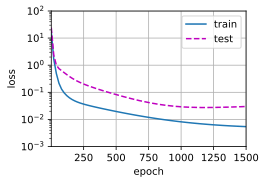

In [8]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

Nas seções subsequentes, continuaremos
a discutir problemas de *overfitting*
e métodos para lidar com eles,
como *weight decay* e *dropout*.


## Resumo

* Uma vez que o erro de generalização não pode ser estimado com base no erro de treinamento, simplesmente minimizar o erro de treinamento não significa necessariamente uma redução no erro de generalização. Os modelos de *machine learning* precisam ter cuidado para evitar *overfitting*, de modo a minimizar o erro de generalização.
* Um conjunto de validação pode ser usado para seleção de modelo, desde que não seja usado com muita liberalidade.
* *Underfitting* significa que um modelo não é capaz de reduzir o erro de treinamento. Quando o erro de treinamento é muito menor do que o erro de validação, há *overfitting*.
* Devemos escolher um modelo apropriadamente complexo e evitar o uso de amostras de treinamento insuficientes.


## Exercícios

1. Você pode resolver o problema de regressão polinomial exatamente? Dica: use álgebra linear.
1. Considere a seleção de modelo para polinômios:
     1. Plote a perda de treinamento vs. complexidade do modelo (grau do polinômio). O que você observa? Que grau de polinômio você precisa para reduzir a perda de treinamento para 0?
     1. Trace a perda de teste neste caso.
     1. Gere o mesmo gráfico em função da quantidade de dados.
1. O que acontece se você descartar a normalização ($1/i!$) Das feições polinomiais $x^i$? Você pode consertar isso de outra maneira?
1. Você pode esperar ver erro de generalização zero?


[Discussions](https://discuss.d2l.ai/t/96)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTY3NzA1MzA3NiwxMzYxMzM2ODgxLDExNz
U2NjQ1MTYsLTUwOTUwODc2NCw4NTQ4NjYzNzIsMTQ0Mzc1OTkz
LDQ5Mzk5Njc3NywtMTI1MjkxNjkwOCwtMTA0MDk2OTkyNV19
-->
